In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.cm as cm
% matplotlib notebook 
import numpy as np
import random

In [32]:
class grid_map:
    def __init__(self, n = 10, obst_dens = 0.15, time = 0):
        self.n = n
        self.obst_dens = obst_dens
        self.grid = np.zeros(shape = (n,n))
        self.time = 0
        #make walls at the borders
        for i in range(n): 
            self.grid[0,i] = -100
            self.grid[i,0] = -100
            self.grid[n-1,i] = -100
            self.grid[i,n-1] = -100
        self.random_obstacles()
        self.place_robot()
    
    def random_obstacles(self):
        for i in range(1, self.n - 1):
            for j in range(1, self.n - 1):
                if random.random() < self.obst_dens and self.grid[i,j] == 0: self.grid[i,j] = -100
                    
                    
    def place_robot(self):
        placed = False
        while not placed:
            i, j  = random.randint(1, self.n - 1), random.randint(1, self.n - 1)
            if self.grid[i,j] == 0: 
                #self.grid[i,j] = 2
                self.pos = [i,j]
                placed = True
                                
                    
    def straight_until_wall(self, direction = None):
        if not direction: direction = random.randint(0, 3)
        #check if we can move in wanted direction
        if direction == 0: 
            if self.grid[self.pos[0] + 1, self.pos[1]] >= 0: self.pos[0] += 1
            else: direction = random.randint(0, 3)       
                        
        elif direction == 1:
            if self.grid[self.pos[0], self.pos[1] + 1] >= 0: self.pos[1] += 1
            else: direction = random.randint(0, 3) 
            
        elif direction == 2:
            if self.grid[self.pos[0] - 1, self.pos[1]] >= 0: self.pos[0] -= 1
            else: direction = random.randint(0, 3) 
            
        elif direction == 3:
            if self.grid[self.pos[0], self.pos[1] - 1]  >= 0: self.pos[1] -= 1
            else: direction = random.randint(0, 3)
            
        self.grid[self.pos[0], self.pos[1]] += 1
        self.time += 1
        return direction
            
    
    def observe(self):
        plt.clf()
        #plt.matshow(self.grid, cmap=cm.viridis)        
        plt.scatter(self.pos[1], self.pos[0], c='r')  
        plt.title('timestep : %s'%self.time)
        plt.imshow(self.grid, cmap=cm.viridis, interpolation='none')
        plt.show()
        
    
    #Remove obstacles from array so we can measure performance
    def tiles(self):
        flat = np.ndarray.flatten(self.grid)
        out = []
        for tile in flat:
            if tile >= 0:
                out.append(tile)
        return np.asarray(out)
                    

In [33]:
#Gini coefficient calculating function taken from: https://github.com/oliviaguest/gini

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

<IPython.core.display.Javascript object>


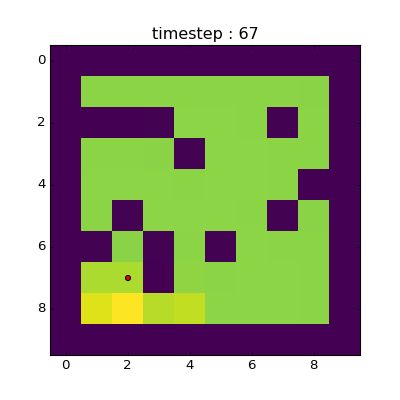

In [37]:
def animate(i):
    direction = None
    for t in  range(1):
        directon = Sim.straight_until_wall(direction)
    Sim.observe()

    
Sim = grid_map(obst_dens = 0.15)
fig = plt.figure(figsize = (5,5))  
ani = animation.FuncAnimation(fig, animate, frames= 1000,
                    interval = 1, blit= True, repeat = False)


In [35]:
gini(Sim.tiles())

0.75455719105904118

In [36]:
Sim.tiles()

array([ 0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  3.,  0.,  0.,
        0.,  0.,  0.,  1.,  3.,  4.,  0.,  0.,  0.,  0.,  2.,  3.,  0.,
        0.,  0.,  0.,  0.,  1.,  3.,  5.,  4.,  3.,  0.,  0.,  0.,  1.,
        0.,  1.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.])

### Inequality after a fixed number of steps

In [ ]:
gini_list = []
for i in range(1000):
    Sim = grid_map(obst_dens = 0.15)
    direction = None
    for _ in range(2000):
        directon = Sim.straight_until_wall(direction)
    gini_list.append(gini(Sim.tiles()))

In [ ]:
plt.hist(gini_list)
plt.show()